In [114]:
from matplotlib import pyplot as plt
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST

In [115]:
os.chdir('/Users/rraj/PythonFunctions/DCNet/')
os.getcwd()

'/Users/rraj/PythonFunctions/DCNet'

In [116]:
LATENT_DIM = 2
NEPOCHS = 100
BATCH_SIZE = 256
LEARNING_RATE = 0.001

DC_OUT_DIM = 500
DC_NEPOCHS = 5
DC_NBATCHES = 20

In [117]:
mnist_data = MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.ToTensor(), 
    download = True,            
)

mnist_test_data = MNIST(
    root = 'data',
    train = False,                         
    transform = transforms.ToTensor(), 
    download = True,            
)

In [118]:
EMBEDDINGS = torch.load('embeddings_dcnet_500.pt')
TARGETS = torch.load('targets_dcnet_500.pt')

class EmbeddingsDCNet(Dataset):
    def __init__(self) -> None:
        super().__init__()
        
    def __len__(self):
        return len(EMBEDDINGS)
    
    def __getitem__(self, index):
        return EMBEDDINGS[index], TARGETS[index]

In [119]:
class EncoderDCNet(nn.Module):
    def __init__(self, out_dim: int, latent_dim: int) -> None:
        super().__init__()
        self.linear1 = nn.Linear(out_dim, 128)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(32, latent_dim)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_ = self.linear1(x)
        x_ = self.relu1(x_)
        x_ = self.linear2(x_)
        x_ = self.relu2(x_)
        x_ = self.linear3(x_)
        x_ = self.relu3(x_)
        x_f = self.linear4(x_)
        return x_f

class DecoderDCNet(nn.Module):
    def __init__(self, out_dim: int, latent_dim: int) -> None:
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, 32)
        self.norm1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(32, 64)
        self.norm2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(64, 128)
        self.norm3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(128, out_dim)
        self.relu4 = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_ = self.linear1(x)
        x_ = self.norm1(x_)
        x_ = self.relu1(x_)
        x_ = self.linear2(x_)
        x_ = self.norm2(x_)
        x_ = self.relu2(x_)
        x_ = self.linear3(x_)
        x_ = self.norm3(x_)
        x_ = self.relu3(x_)
        x_ = self.linear4(x_)
        x_f = self.relu4(x_)
        return x_f        

In [120]:
from torch.utils.data.sampler import SubsetRandomSampler

encoder_dc = EncoderDCNet(DC_OUT_DIM, LATENT_DIM)
decoder_dc = DecoderDCNet(DC_OUT_DIM, LATENT_DIM)

THRESHOLDS = [0.4, 0.3, 0.2, 0.15, 0.125]

parameters_to_optimize_dc = [
    {'params': encoder_dc.parameters()},
    {'params': decoder_dc.parameters()}
]

loss_fn = nn.MSELoss()
optimizer_dc = torch.optim.Adam(parameters_to_optimize_dc, lr=LEARNING_RATE, weight_decay=1e-5)

embedding_data = EmbeddingsDCNet()
shuffled_index = torch.randperm(len(embedding_data))
split = int(0.8*len(embedding_data))
train_indexes, test_indexes = shuffled_index[:split], shuffled_index[split:]
embedding_loader = DataLoader(embedding_data, batch_size=10*BATCH_SIZE, sampler=SubsetRandomSampler(train_indexes))
test_loader = DataLoader(embedding_data, batch_size=10*BATCH_SIZE, sampler=SubsetRandomSampler(test_indexes))

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoder_dc.to(device)
decoder_dc.to(device)

print(device)

cpu


In [121]:
from plotting import LossPlotter
plotter = LossPlotter()

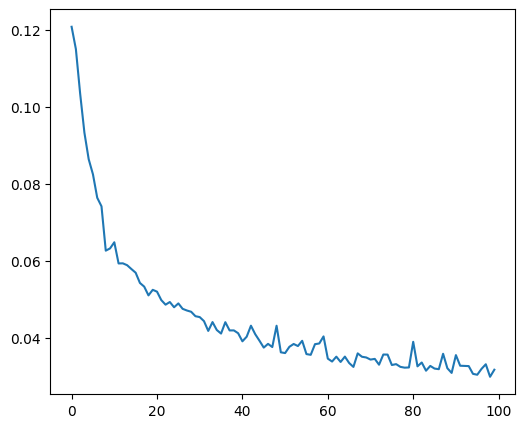

In [122]:
from layers import SequentialAttention
attention_layers = SequentialAttention(DC_OUT_DIM, nlayers=len(THRESHOLDS), thresholds=THRESHOLDS, strengths=0.3)

nkeys = []

encoder_dc.train()
decoder_dc.train()

for epoch in range(NEPOCHS):
    running_loss = 0
    for data, targets in tqdm(embedding_loader, total=len(embedding_loader), desc=f"Epoch:{epoch+1}/{NEPOCHS}"):
        data = attention_layers(data)
        data.to(device)
            
        optimizer_dc.zero_grad()
            
        encoder_output = encoder_dc(data)
        decoder_output = decoder_dc(encoder_output)
        loss = loss_fn(data, decoder_output)
            
        loss.backward()
        optimizer_dc.step()
        
        nkeys.append(attention_layers.nkeys)
    plotter(loss.item())

In [123]:
print(attention_layers.nkeys)

[2125, 495, 129, 64, 47]


In [124]:
encoder_dc.eval()
decoder_dc.eval()

inputs_dc, targets_dc, latents_dc, reconstructions_dc = [], [], [], []

with torch.no_grad():
    for data, target in tqdm(test_loader, total=len(test_loader)):
        embeddings_dc = attention_layers(data, train=False)
        inputs_dc.append(embeddings_dc)
        targets_dc.append(target)
        
        embeddings_dc.to(device)
        
        encoder_output = encoder_dc(embeddings_dc)
        decoder_output = decoder_dc(encoder_output)
        
        latents_dc.append(encoder_output.cpu())
        reconstructions_dc.append(decoder_output.cpu())

100%|██████████| 5/5 [00:01<00:00,  2.98it/s]


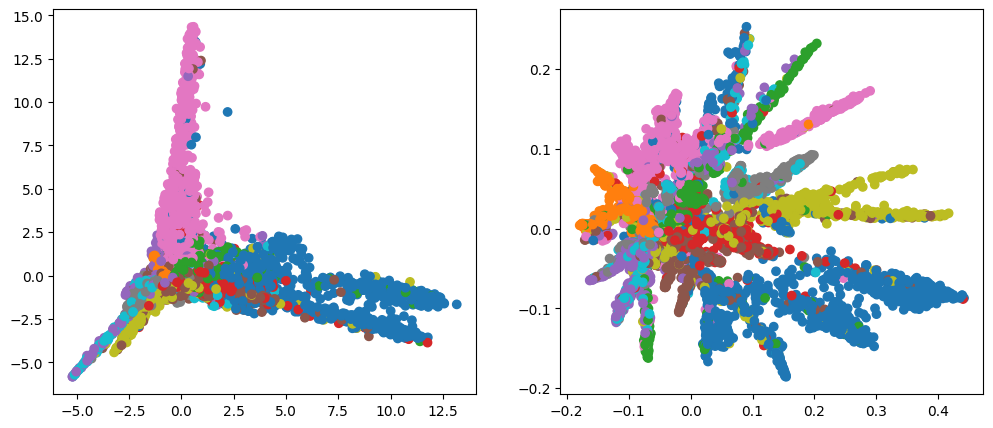

In [125]:
from sklearn.decomposition import PCA

latents_combined_dc = torch.empty(0)
targets_combined_dc = torch.empty(0)
inputs_combined_dc = torch.empty(0)
reconstructions_combined_dc = torch.empty(0)
for latent, target, input, recon in zip(latents_dc, targets_dc, inputs_dc, reconstructions_dc):
    latents_combined_dc = torch.cat((latents_combined_dc, latent), dim=0)
    targets_combined_dc = torch.cat((targets_combined_dc, target), dim=0)
    inputs_combined_dc = torch.cat((inputs_combined_dc, input), dim=0)
    reconstructions_combined_dc = torch.cat((reconstructions_combined_dc, recon), dim=0)
    
latent_projections_dc = PCA(n_components=2).fit_transform(latents_combined_dc)
input_projections_dc = PCA(n_components=2).fit_transform(inputs_combined_dc)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].scatter(input_projections_dc[:,0], input_projections_dc[:,1], c=targets_combined_dc, cmap='tab10')
ax[1].scatter(latent_projections_dc[:,0], latent_projections_dc[:,1], c=targets_combined_dc, cmap='tab10')

In [126]:
from layers import AttentionModule
attention_layers_copy = SequentialAttention(DC_OUT_DIM, nlayers=len(THRESHOLDS), thresholds=THRESHOLDS)
one_hot_layer = AttentionModule(10, threshold=0.1, one_hot_values=True)

nkeys_copy = []

for epoch in tqdm(range(NEPOCHS)):
    for data, target in embedding_loader:
        data = attention_layers_copy(data)
        data = one_hot_layer(data, targets=target)
        
        nkeys_copy.append(attention_layers.nkeys)

100%|██████████| 100/100 [15:45<00:00,  9.45s/it]


In [127]:
inputs_dc_one_hot_attn, targets_dc_one_hot_attn, outputs_dc_one_hot_attn = [], [], []

with torch.no_grad():
    for data, target in tqdm(test_loader, total=len(test_loader)):
        embeddings_dc = attention_layers(data, train=False)
        inputs_dc_one_hot_attn.append(embeddings_dc)
        targets_dc_one_hot_attn.append(target)
        
        out = one_hot_layer(data, targets=target, train=False)
        outputs_dc_one_hot_attn.append(out)

100%|██████████| 5/5 [00:01<00:00,  3.14it/s]


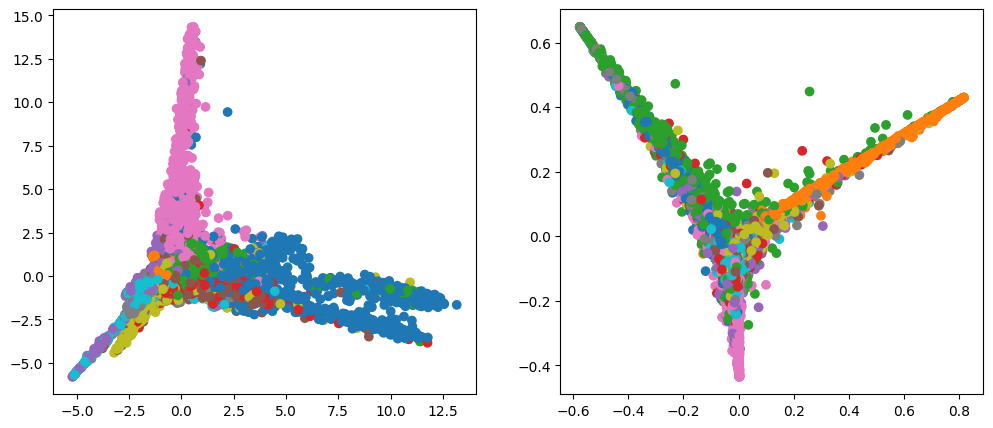

In [128]:
targets_combined_dc_one_hot_attn = torch.empty(0)
inputs_combined_dc_one_hot_attn = torch.empty(0)
outputs_combined_dc_one_hot_attn = torch.empty(0)
for output, target, input in zip(outputs_dc_one_hot_attn, targets_dc_one_hot_attn, inputs_dc_one_hot_attn):
    outputs_combined_dc_one_hot_attn = torch.cat((outputs_combined_dc_one_hot_attn, output), dim=0)
    targets_combined_dc_one_hot_attn = torch.cat((targets_combined_dc_one_hot_attn, target), dim=0)
    inputs_combined_dc_one_hot_attn = torch.cat((inputs_combined_dc_one_hot_attn, input), dim=0)
    
output_projections_dc_one_hot_attn = PCA(n_components=2).fit_transform(outputs_combined_dc_one_hot_attn)
input_projections_dc_one_hot_attn = PCA(n_components=2).fit_transform(inputs_combined_dc_one_hot_attn)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].scatter(input_projections_dc_one_hot_attn[:,0], input_projections_dc_one_hot_attn[:,1], c=targets_combined_dc_one_hot_attn, cmap='tab10')
ax[1].scatter(output_projections_dc_one_hot_attn[:,0], output_projections_dc_one_hot_attn[:,1], c=targets_combined_dc_one_hot_attn, cmap='tab10')

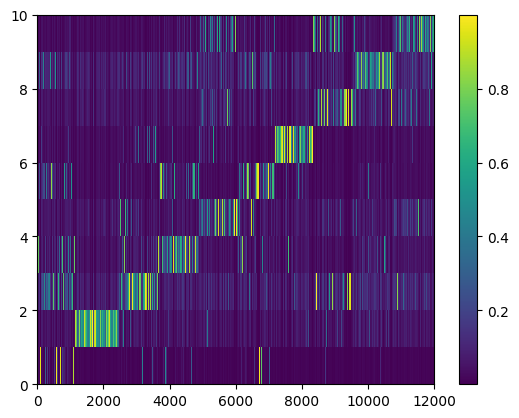

In [129]:
sorted_idx = torch.argsort(targets_combined_dc_one_hot_attn)
plt.pcolormesh(outputs_combined_dc_one_hot_attn[sorted_idx].T)
plt.colorbar()

In [130]:
(torch.argmax(outputs_combined_dc_one_hot_attn, dim=1) == targets_combined_dc_one_hot_attn).sum()/12000

tensor(0.5618)

In [131]:
all_pos_idxs = (TARGETS == TARGETS[0]).nonzero().flatten()
rand_idx = torch.randint(len(all_pos_idxs),(1,))
pos_idx = all_pos_idxs[rand_idx]
EMBEDDINGS[pos_idx].shape

torch.Size([1, 500])